# 0: Dataset

In [24]:
# some globals we use further down

# we take the n most-frequent words from our corpus as our vocabulary
MAX_WORDS = 10_000  

# we consider the first n words from a review for classification and ignore the rest
MAX_LEN = 20

## Dataset: IMDB review

In [5]:
from tensorflow.keras.datasets import imdb

In [6]:
(train_data, train_labels), (test_data, _test_labels) = imdb.load_data(num_words=MAX_WORDS)

## Input data

Each sample is a sequence of integers, each integer encodes a single word.

In [7]:
train_data[100][:10]  # only print the first few

[1, 13, 244, 6, 87, 337, 7, 628, 2219, 5]

In [8]:
def to_text(sample, max_words=50):
    word_index = imdb.get_word_index()
    reverse_index = {value: key for key, value in word_index.items()}
    return " ".join([reverse_index[num] for num in sample[:max_words]])

to_text(train_data[100])

"the was rather is him completely br english send to one dvd for kind way are year type but tired talent of am stories slightest coop on her no was although some has as was garbage che's that to to when it as if is herself br and door simply"

Labels define the sentiment of the review. Reviews ar either negative (=0) or positive(=1). This is the task we will teach our network: For an given sequence of words (=a IMDB review), infer the sentiment encoded as a number.

In [9]:
train_labels[:10]  # sentiment labels of first 10 samples

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

## Turn input sequences into vectors

Neural nets require numerical input of fixed length. We transform our input samples (variable sized list of word) into one-hot vectors over a fixed vocabulary. **TODO**: this is not one-hot, we have multiple 1s per vector. is this a bag of words representation?

In [10]:
import numpy as np

In [34]:
def vectorize_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [57]:
from tensorflow.keras import preprocessing

def load_imdb_data(representation='raw', num_words=MAX_WORDS, seq_maxlen=None):
    """
    Load IMDB dataset in a given representation
    
    :param representation:
        Which format ro return the dataset in. Possible values:
        - raw: A sample is a sequence of arbitrary length, 
               each entry of that sequence is an integer 
               which represents one word from the corpus.
        - bow: Bag of words. A sample is a sequence of length <num_words>.
               Each index in that sequence stands for one word in the corpus.
               At indexes where the word is part of the sample, the entry is 1
               At indexes where the word is not in the sample, the entry is 0
        - seq: Representation useful for input to embedding layers. 
               Each sample is a sequence of the same length <maxlen>

    :param num_words: 
        maximum number of words to include. 
        
    :param seq_maxlen:
        maximum length of all sequences. Only used for representatin 'sequences'

        
    :return:
        Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
    
    """
    
    if representation not in ('raw', 'seq', 'bow'):
        raise ValueError('Incorrect value for parameter: representation')
    
    # todo: cache this part
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_WORDS)
    
    if representation == 'bow':
        x_train = vectorize_sequences(x_train, num_words)
        x_test = vectorize_sequences(x_test, num_words)
    elif representation == 'seq':
        if not seq_maxlen:
            raise ValueError('Missing parameter: seq_maxlen')
        x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=seq_maxlen)
        x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=seq_maxlen)
        
    return (x_train, y_train), (x_test, y_test)

In [56]:
(x_train_bow, y_train_bow), (x_test, y_test) = load_imdb_data(representation='bow')

x_train_bow[0]

array([0., 1., 1., ..., 0., 0., 0.])

---

# 1: MLP

## Model Definition

As a first (simple) model to process sequences, we'll create Multilayer Perceptron with 2 hidden layers (16 units each, ReLU activation) and an output layer that maps the input to the range from 0 (=negative review) to 1 (=positive review).

In [42]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [67]:
model = models.Sequential()
model.add(layers.Dense(16, input_shape=(MAX_WORDS,), activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [68]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


## Model training

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [70]:
history_bow = model.fit(x=x_train_bow, 
                    y=y_train_bow,
                    validation_split=0.2,
                    epochs=10)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 129us/sample - loss: 0.3361 - binary_accuracy: 0.8626 - val_loss: 0.2792 - val_binary_accuracy: 0.8880
Epoch 2/10
20000/20000 [==============================] - 2s 107us/sample - loss: 0.1801 - binary_accuracy: 0.9334 - val_loss: 0.3101 - val_binary_accuracy: 0.8854
Epoch 3/10
20000/20000 [==============================] - 2s 108us/sample - loss: 0.1266 - binary_accuracy: 0.9529 - val_loss: 0.3544 - val_binary_accuracy: 0.8740
Epoch 4/10
20000/20000 [==============================] - 2s 108us/sample - loss: 0.0797 - binary_accuracy: 0.9720 - val_loss: 0.4574 - val_binary_accuracy: 0.8690
Epoch 5/10
20000/20000 [==============================] - 2s 109us/sample - loss: 0.0506 - binary_accuracy: 0.9827 - val_loss: 0.5133 - val_binary_accuracy: 0.8678
Epoch 6/10
20000/20000 [==============================] - 2s 110us/sample - loss: 0.0320 - binary_accuracy: 0.9893 - val_loss: 0.58

In [71]:
import matplotlib.pyplot as plt

def plot_history(history):
    metrics_per_plot =(('loss', 'val_loss'), ('binary_accuracy', 'val_binary_accuracy'))
    for plot in metrics_per_plot:
        for metric in plot:
            plt.plot(history.history[metric], label=metric)
        plt.legend()
        plt.show()

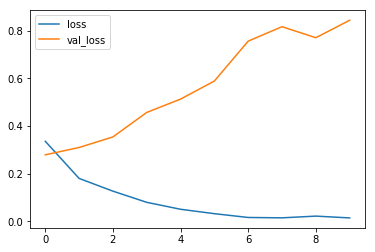

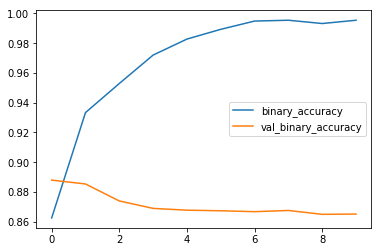

In [72]:
plot_history(history_bow)

## (More) advanced approaches for text and sequences

With a simple MLP we have achieved ~97% validation accuracy on a binary classifcation task using the IMDB dataset. 
Amonsgt the more advanced deep learning approaches in this area, **recurrent neural networks** and **1D convnets** are probably the most popular.

We can use them fore the following tasks:
    
- document classification, timeseries classification 
- timeseries comparison
- sequence-to-sequence learning
- sentiment analysis (like the IMDB example)
- timeseries forecasting

### Working with text data

Our networks require numerical input.
To work with text, we tokenize it = turn a text into tokens.
Tokenization can happen on 3 levels:
    - each character becomes a token
    - each word becomes a token
    - n-grams of words or characters become tokens.

The tokens are either a sequence, or a set (=bag). bag-of-words is n ot order preserving and is kind of feature engineering. We want to let the deep neural net learn such representations, so bag-of-words approaches are usually only used in shallow learning. In that space however, they are a powerful tool.

Then, we need to turn sequences or sets of tokens into vectors. Two popular approaches: *one-hot encodings* or *token embeddings* (typically *word embeddings*)


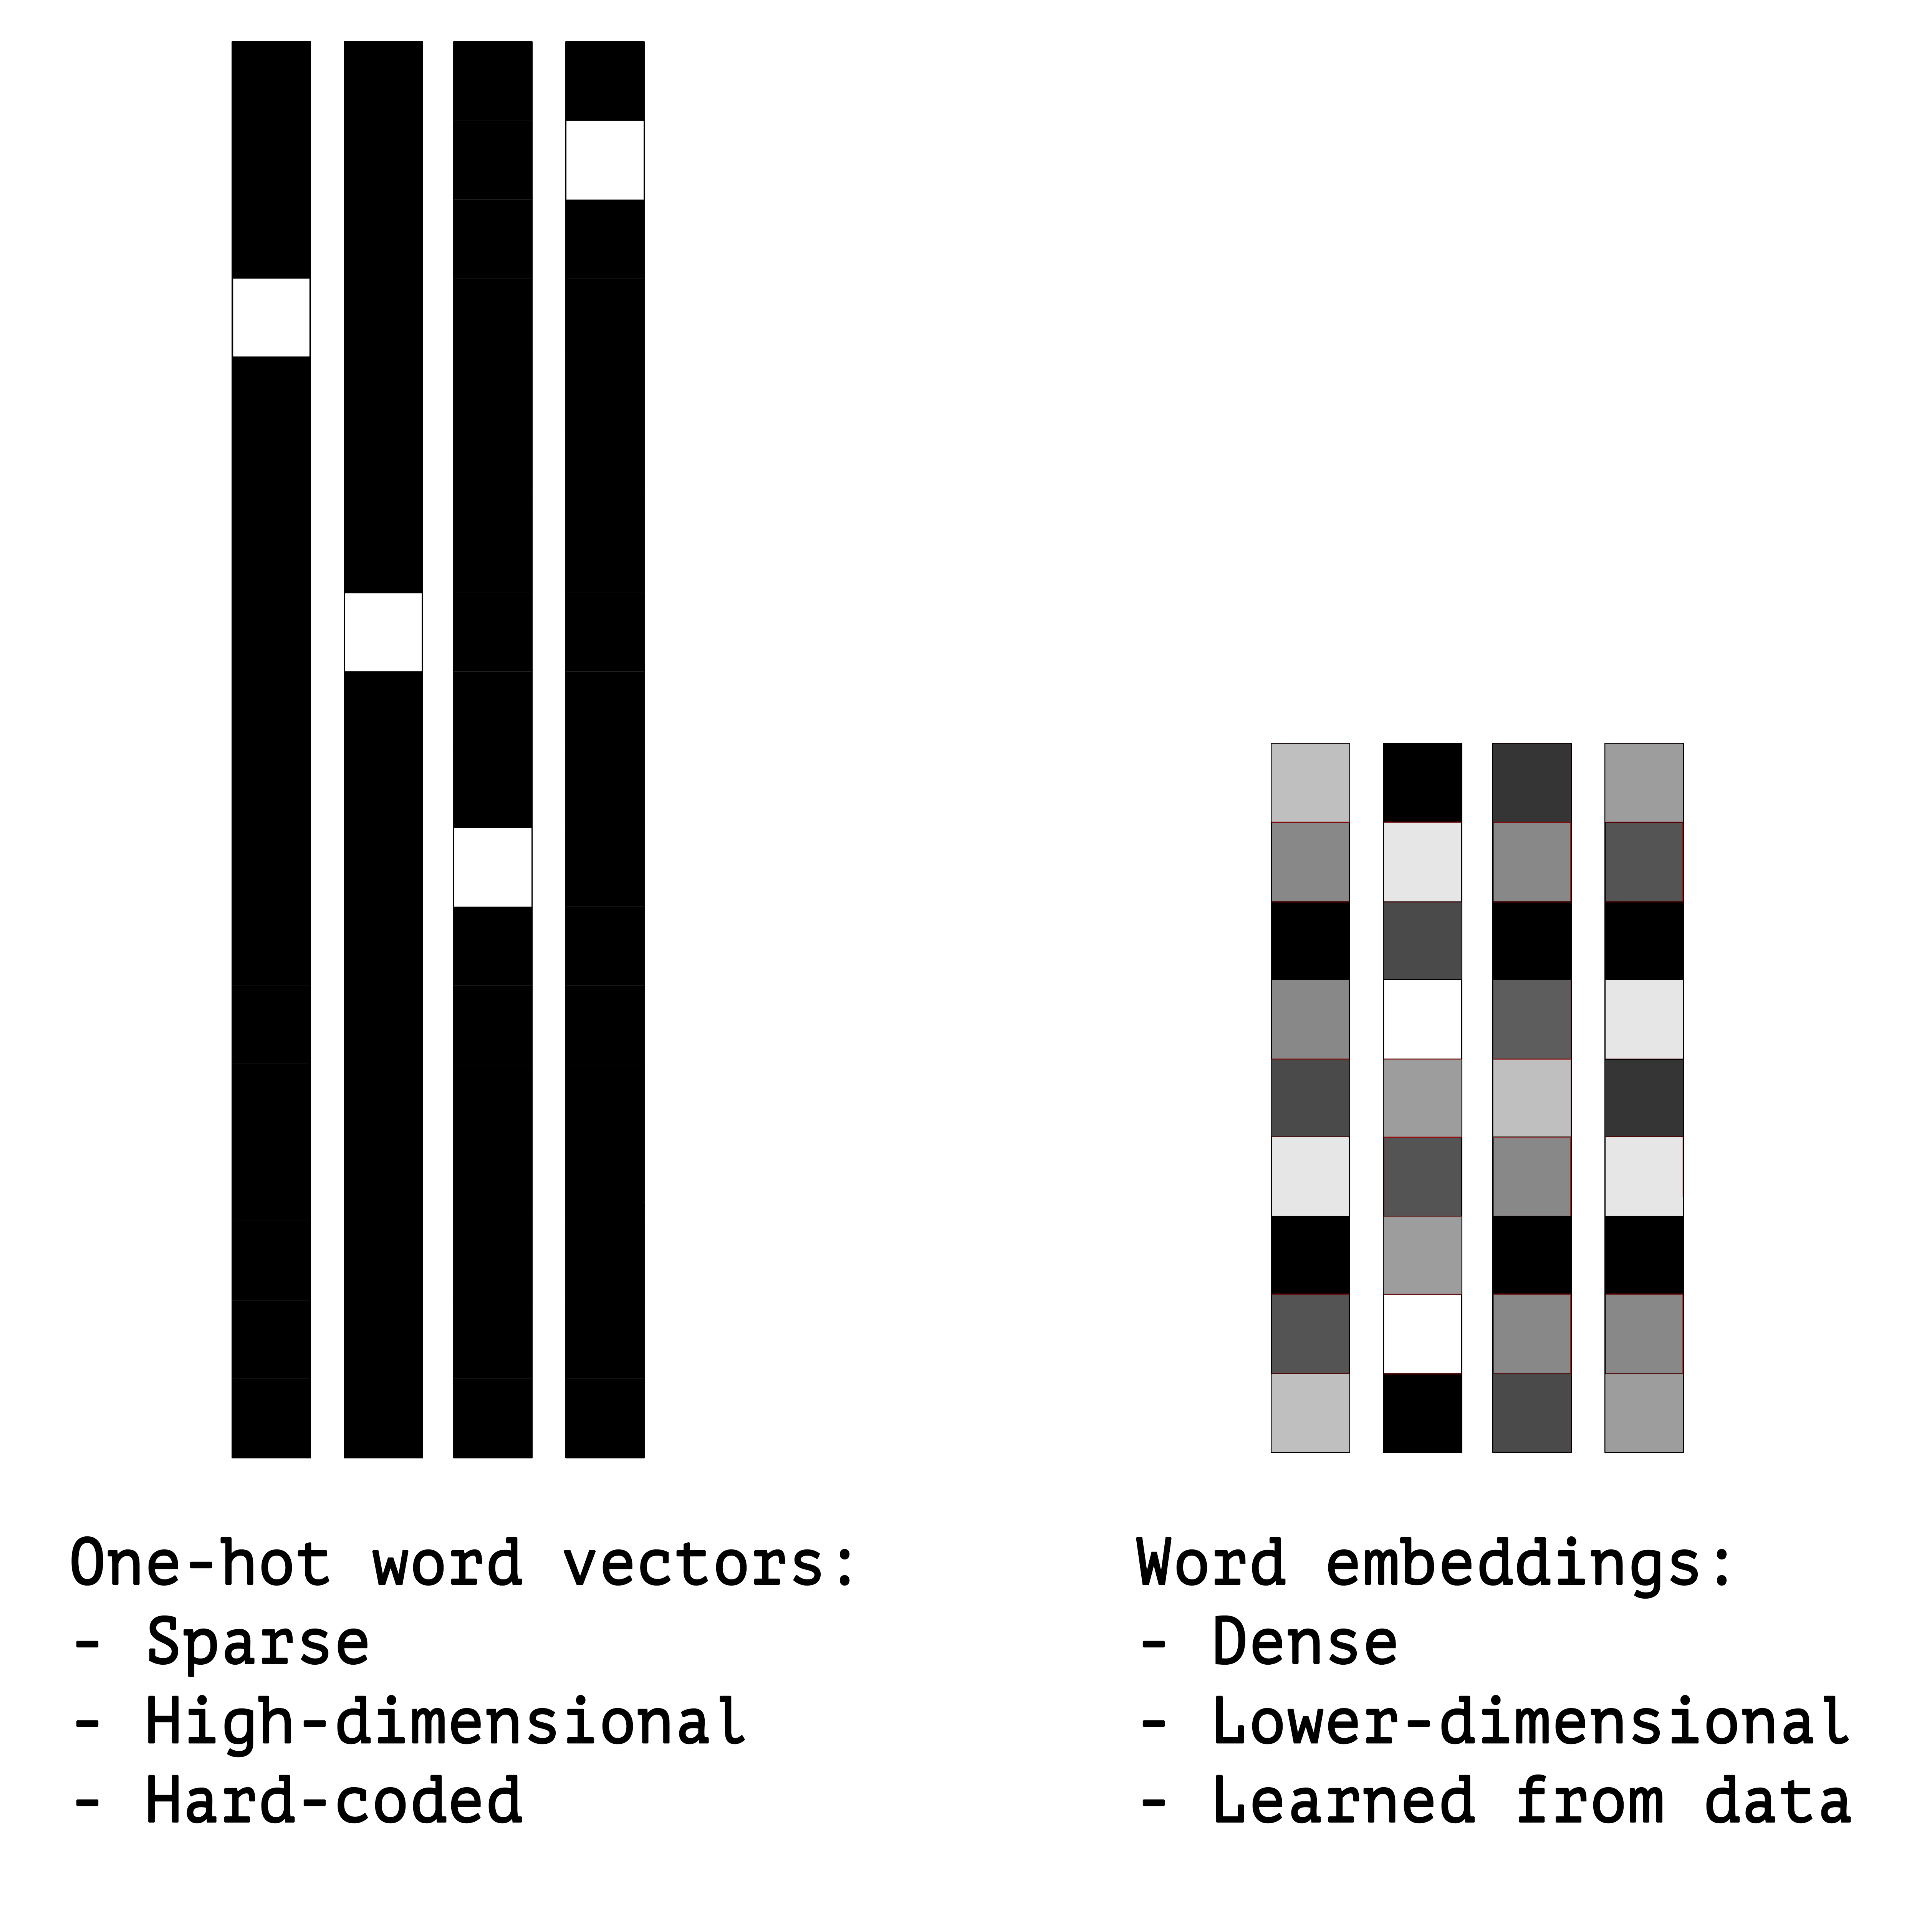

Source: https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/6.1-using-word-embeddings.nb.html

Word embeddings could just map dense vectors to random vectors (of lower dimensionality).
However, neural nets cannot usually make sense of such noisy spaces. What we want instead is
a representation where semantics of the input somehow reflect in the embedding space. For 
example, distances and directions in embedding space should (and can!) be meaningful.

### Train model with embedding layer

In [58]:
(x_train_seq, y_train_seq), (x_test_seq, y_test_seq) = load_imdb_data(representation='seq', seq_maxlen=MAX_LEN)

In [60]:
x_train_seq.shape

(25000, 20)

In [74]:

def train_mlp_with_embedding(x_train, y_train,
                             dim_input=MAX_WORDS,
                             dim_embeddings=8, 
                             input_length=MAX_LEN,
                             epochs=10):
    model = models.Sequential()
    model.add(layers.Embedding(dim_input, dim_embeddings, input_length=input_length))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',  # TODO: adam vs rmsprop 
                  loss='binary_crossentropy',  # TODO: loss functions
                  metrics=['binary_accuracy'])
    model.summary()
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)
    return history



history_embedding = train_mlp_with_embedding(x_train_seq, y_train_seq)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 63us/sample - loss: 0.6617 - binary_accuracy: 0.6460 - val_loss: 0.6069 - val_binary_accuracy: 0.7010
Epoch 2/10
20000/20000 [==============================] - 1s 46us/sample - loss: 0.5326 - binary_accuracy: 0.7584 - val_loss: 0.5238 - val_binary_accuracy: 0.7304
Epoch

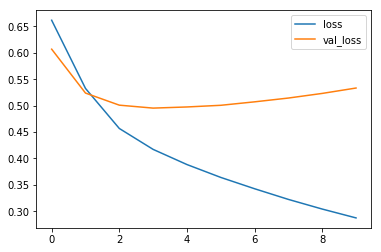

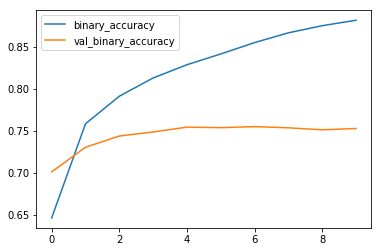

In [75]:
plot_history(history_embedding)

As next steps: embeddings make more sense if they come from a larger corpus. We could use pre-trained embeddings such as word2vec or GloVE.

Also, the current model does not take into account the order of words. Let's move to recurrent neural networks.

**TODO**